In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import loguniform
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
from os import listdir
from sklearn.metrics import roc_curve, auc, log_loss, precision_score,recall_score,f1_score
from sklearn.model_selection import RandomizedSearchCV
import xgboost

import cv2
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


# Read heat map images and converting it to flatten array

In [2]:
path = "X:\\Eye_tracking_Processed_Raw_videos\\CNN_data\\72pp\\"
fl = []
for f in listdir(path):
    tl = []
    
    
    if "emp" in f:
        emp=1
    else:
        emp=0
    
    im = cv2.imread(path+f)
    im = cv2.resize(im, (128,96), interpolation = cv2.INTER_AREA)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = im/255
    im = im.flatten()
    l=list(im)
    
    name = f.split(".")[0]
    name = name.split("_")[0]
    tl.append(name)
    tl.append(emp)
    tl.extend(l)
    fl.append(tl)
#     print(name)
#     print(f)

l = ["Names","target"]
for i in range(1,12289):
    l.append("f_"+str(i))
dfhm = pd.DataFrame(fl,columns=l)

# Finding right "n" for PCA on heat map flatten images

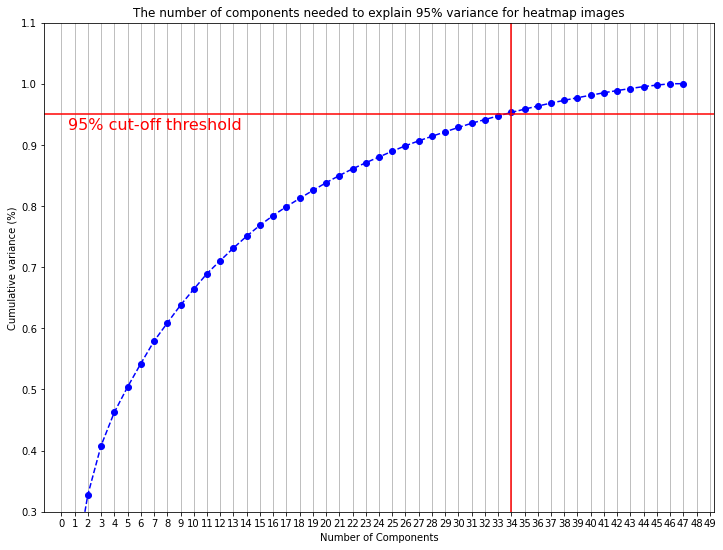

In [3]:
pca = PCA().fit(dfhm.drop(['Names','target'],axis=1))

plt.rcParams["figure.figsize"] = (12,9)

fig, ax = plt.subplots()
xi = np.arange(1, 48, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.3,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 50, step=1)) #change from 0-based array index to 1-based human-readable label
# plt.yticks(np.arange(0.7, 1.1, step=0.1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain 95% variance for heatmap images')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=34, color='r', linestyle='-')

plt.text(0.5, 0.925, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

# Applying PCA

In [4]:
pca_heatmap = PCA(n_components = 34)
pca_heatmap.fit(dfhm.drop(['Names','target'],axis=1))
reduced = pca_heatmap.transform(dfhm.drop(['Names','target'],axis=1))
l=[]
for i in range(1,35):
    l.append("PCA_heatmap"+str(i))
    
dfpca = pd.DataFrame(reduced,columns=l)
dfpca['index']=dfpca.index
dfhm['index']=dfhm.index
dfhm = dfhm[['Names','target','index']].merge(dfpca,on='index')

# Reading final data

In [5]:
df = pd.read_excel("X:\Eye_tracking_Processed_Raw_videos\\thesis_final_2.xlsx")

In [6]:
df['index']=df.index
df.columns

Index(['Names', 'Age', 'Sex', 'before', 'after', 'difference', 'memory', 'eeq',
       'ADR', 'ADL', 'blink_mean', 'blink_std', 'saccade_mean', 'saccade_std',
       'saccade_per', 'blink_per', 'std_l0', 'std_l10', 'std_l25', 'std_l50',
       'std_l75', 'std_l90', 'std_l100', 'std_r0', 'std_r10', 'std_r25',
       'std_r50', 'std_r75', 'std_r90', 'std_r100', 'min_l10', 'min_l25',
       'min_l50', 'min_l75', 'min_l90', 'min_l100', 'min_r10', 'min_r25',
       'min_r50', 'min_r75', 'min_r90', 'min_r100', 'index'],
      dtype='object')

In [7]:
dfp = df[['std_l0', 'std_l10', 'std_l25', 'std_l50',
       'std_l75', 'std_l90', 'std_l100', 'std_r0', 'std_r10', 'std_r25',
       'std_r50', 'std_r75', 'std_r90', 'std_r100', 'min_l10', 'min_l25',
       'min_l50', 'min_l75', 'min_l90', 'min_l100', 'min_r10', 'min_r25',
       'min_r50', 'min_r75', 'min_r90', 'min_r100']]

# Finding right "n" for pupil dilation features

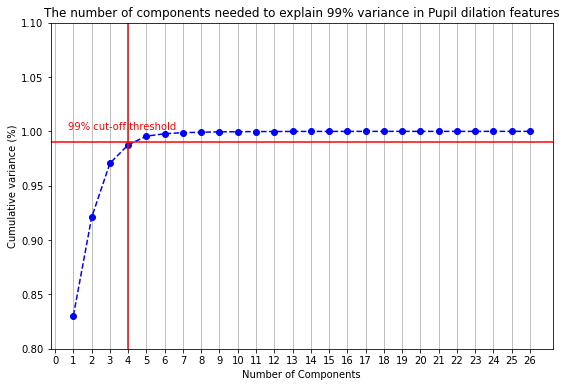

In [8]:
pca_pupil = PCA().fit(dfp)

plt.rcParams["figure.figsize"] = (9,6)

fig, ax = plt.subplots()
xi = np.arange(1, len(dfp.columns)+1, step=1)
y = np.cumsum(pca_pupil.explained_variance_ratio_)

plt.ylim(0.8,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(dfp.columns)+1, step=1)) #change from 0-based array index to 1-based human-readable label
# plt.yticks(np.arange(0.7, 1.1, step=0.1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain 99% variance in Pupil dilation features')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.axvline(x=4, color='r', linestyle='-')

plt.text(0.72, 1.002, '99% cut-off threshold', color = 'red', fontsize=10)

ax.grid(axis='x')
plt.show()

# PCA on pupil dilation features

In [9]:
pca_pupil = PCA(n_components = 4)
pca_pupil.fit(dfp)
reduced = pca_pupil.transform(dfp)

In [10]:
df_pupil = pd.DataFrame(reduced,columns=['pca_pupil_1','pca_pupil_2','pca_pupil_3','pca_pupil_4'])
df_pupil['index']=df_pupil.index
df['peak_pupil_dilation'] = (df['min_l100']+df['min_r100'])/2

In [11]:
df.drop(['std_l0', 'std_l10', 'std_l25', 'std_l50',
       'std_l75', 'std_l90', 'std_l100', 'std_r0', 'std_r10', 'std_r25',
       'std_r50', 'std_r75', 'std_r90', 'std_r100', 'min_l10', 'min_l25',
       'min_l50', 'min_l75', 'min_l90', 'min_l100', 'min_r10', 'min_r25',
       'min_r50', 'min_r75', 'min_r90', 'min_r100'],axis=1,inplace=True)

# Merge pupil and normal data again

In [12]:
df = df.merge(df_pupil,on='index')

# Creating target variable from eeq scores

In [13]:
df['target']=list(map(lambda x: "1" if x>1.2 else "0",df['eeq']))

In [14]:
df['sex'] = list(map(lambda x: 1 if x=="Female" else 0,df['Sex']))

# Merging heat map features with final data

In [15]:
df = df.drop(['index'],axis=1).merge(dfhm.drop(['target','index'],axis=1),on="Names")

In [16]:
df.drop(['Sex','Names','eeq'],axis=1,inplace=True)

In [17]:
df.columns

Index(['Age', 'before', 'after', 'difference', 'memory', 'ADR', 'ADL',
       'blink_mean', 'blink_std', 'saccade_mean', 'saccade_std', 'saccade_per',
       'blink_per', 'peak_pupil_dilation', 'pca_pupil_1', 'pca_pupil_2',
       'pca_pupil_3', 'pca_pupil_4', 'target', 'sex', 'PCA_heatmap1',
       'PCA_heatmap2', 'PCA_heatmap3', 'PCA_heatmap4', 'PCA_heatmap5',
       'PCA_heatmap6', 'PCA_heatmap7', 'PCA_heatmap8', 'PCA_heatmap9',
       'PCA_heatmap10', 'PCA_heatmap11', 'PCA_heatmap12', 'PCA_heatmap13',
       'PCA_heatmap14', 'PCA_heatmap15', 'PCA_heatmap16', 'PCA_heatmap17',
       'PCA_heatmap18', 'PCA_heatmap19', 'PCA_heatmap20', 'PCA_heatmap21',
       'PCA_heatmap22', 'PCA_heatmap23', 'PCA_heatmap24', 'PCA_heatmap25',
       'PCA_heatmap26', 'PCA_heatmap27', 'PCA_heatmap28', 'PCA_heatmap29',
       'PCA_heatmap30', 'PCA_heatmap31', 'PCA_heatmap32', 'PCA_heatmap33',
       'PCA_heatmap34'],
      dtype='object')

In [18]:
y = df['target']
X = df.drop(['target'],axis=1)

# Test train split on data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=23)

In [20]:

def metricss(actual,pred):
    precision=precision_score(actual,pred, average="binary",pos_label='1')
    recall=recall_score(actual,pred, pos_label='1')
    f1=f1_score(actual,pred, average="binary", pos_label='1')
    
    return(precision,recall,f1)

# RF

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# Randomized search of hyperparameters

In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = rfc()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

# Applying model on test data

In [23]:
rf_cv = rf_random.best_estimator_
y_pred = rf_cv.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print("confusion matrix\n",conf_mat)
precision, recall, f1 = metricss(y_test, y_pred)
print("f1 - ",f1)
print("recall - ",recall)
print("precision - ",precision)

confusion matrix
 [[5 0]
 [3 1]]
f1 -  0.4
recall -  0.25
precision -  1.0


# Gradient Boosting

In [25]:
parameters = {
    "n_estimators":[5,50,250,500,1000],
    "max_depth":[1,3,5,7,9,15,20,50],
    "learning_rate":[0.01,0.1,1,10,100],
    "max_depth" : [int(x) for x in np.linspace(10, 110, num = 11)],
    "min_samples_split" : [2, 5, 10],
    "min_samples_leaf" : [1, 2, 4]
}

# Randomized search of hyperparameters

In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbc = GradientBoostingClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = parameters, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
gbc_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 1, 10,
                                                          100],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [5, 50, 250, 500,
                                                         1000]},
                   random_state=42, verbose=1)

# Applying model on test data

In [27]:
gbc_cv = gbc_random.best_estimator_
y_pred = gbc_cv.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print("confusion matrix\n",conf_mat)
precision, recall, f1 = metricss(y_test, y_pred)
print("f1 - ",f1)
print("recall - ",recall)
print("precision - ",precision)

confusion matrix
 [[1 4]
 [3 1]]
f1 -  0.22222222222222224
recall -  0.25
precision -  0.2


# XGB

In [28]:
xgb = xgboost.XGBClassifier()
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
} 

# Randomized search of hyperparameters

In [29]:
xgb_random=RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
xgb_random.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

# Applying model on test data

In [30]:
xgb = xgb_random.best_estimator_
y_pred = xgb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print("confusion matrix\n",conf_mat)
precision, recall, f1 = metricss(y_test, y_pred)
print("f1 - ",f1)
print("recall - ",recall)
print("precision - ",precision)

confusion matrix
 [[5 0]
 [3 1]]
f1 -  0.4
recall -  0.25
precision -  1.0


# LR

# Randomized search of hyperparameters

In [41]:
# random search logistic regression model on the sonar dataset


lr = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
# define search
lr_random = RandomizedSearchCV(lr, space, n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)


In [42]:
# execute search
result = lr_random.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7944444444444444
Best Hyperparameters: {'C': 1.8929246173207592, 'penalty': 'none', 'solver': 'sag'}


C:\Users\aksha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1410 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\aksha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aksha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(

# Applying model on test data

In [43]:
lr_cv = lr_random.best_estimator_
y_pred = lr_cv.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print("confusion matrix\n",conf_mat)
precision, recall, f1 = metricss(y_test, y_pred)
print("f1 - ",f1)
print("recall - ",recall)
print("precision - ",precision)

confusion matrix
 [[4 1]
 [0 4]]
f1 -  0.888888888888889
recall -  1.0
precision -  0.8


# Finding most important features

In [34]:
tmp = pd.DataFrame()

In [46]:
importance = lr_cv.coef_
imp = list(map(lambda x: abs(x),importance[0]))
tmp = pd.DataFrame()
tmp['name']=['Age', 'sadness_level_before', 'sadness_level_after', 'sadness_difference', 'memory', 'ADR', 'ADL',
       'blink_mean', 'blink_std', 'saccade_mean', 'saccade_std', 'saccade_per',
       'blink_per', 'peak_pupil_dilation', 'pca_pupil_1', 'pca_pupil_2',
       'pca_pupil_3', 'pca_pupil_4', 'sex', 'PCA_heatmap1', 'PCA_heatmap2',
       'PCA_heatmap3', 'PCA_heatmap4', 'PCA_heatmap5', 'PCA_heatmap6',
       'PCA_heatmap7', 'PCA_heatmap8', 'PCA_heatmap9', 'PCA_heatmap10',
       'PCA_heatmap11', 'PCA_heatmap12', 'PCA_heatmap13', 'PCA_heatmap14',
       'PCA_heatmap15', 'PCA_heatmap16', 'PCA_heatmap17', 'PCA_heatmap18',
       'PCA_heatmap19', 'PCA_heatmap20', 'PCA_heatmap21', 'PCA_heatmap22',
       'PCA_heatmap23', 'PCA_heatmap24', 'PCA_heatmap25', 'PCA_heatmap26',
       'PCA_heatmap27', 'PCA_heatmap28', 'PCA_heatmap29', 'PCA_heatmap30',
       'PCA_heatmap31', 'PCA_heatmap32', 'PCA_heatmap33', 'PCA_heatmap34']
tmp['val']=imp
tmp.sort_values('val',ascending=False, inplace=True)
tmp['val']=tmp['val']/sum(tmp['val'])

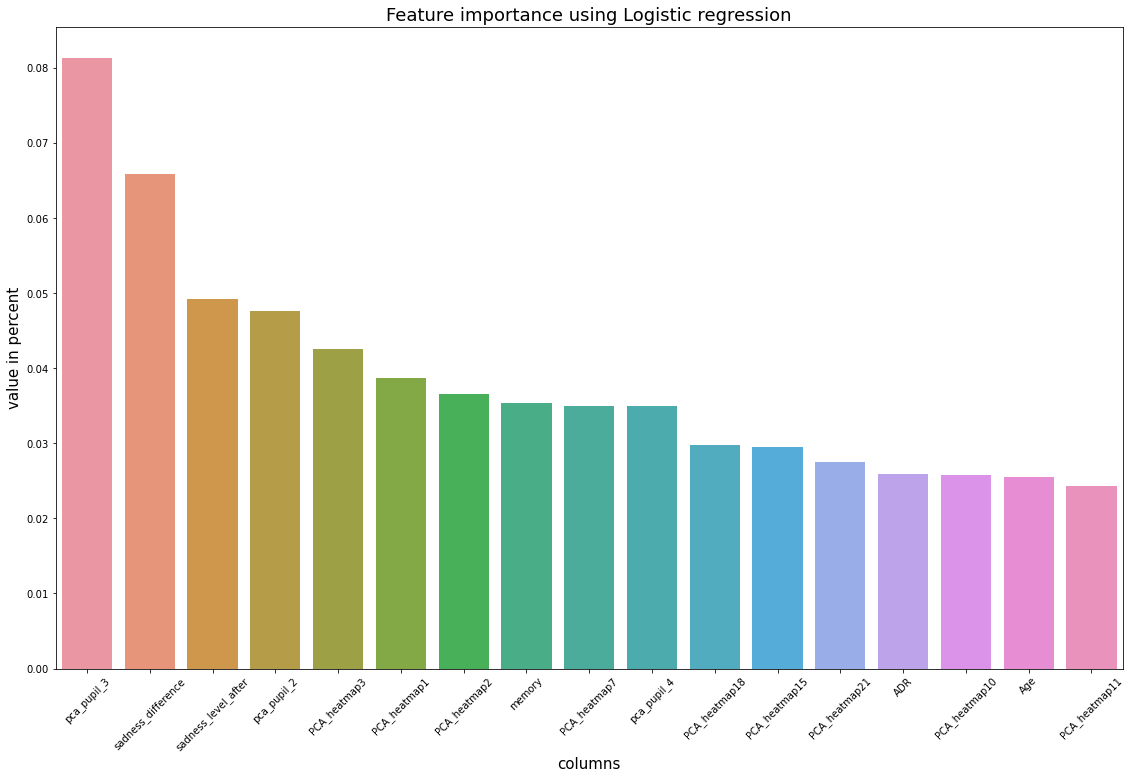

In [49]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
tmp =tmp[:17]

# make barplot and sort bars
sns.barplot(x='name',
            y="val", 
            data=tmp, 
            order=tmp.sort_values('val',ascending=False).name)
# set labels
plt.xlabel("columns", size=15)
plt.ylabel("value in percent", size=15)
plt.title("Feature importance using Logistic regression", size=18)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(r"C:\Users\aksha\Downloads\Thesis img\feature_imp.png", dpi=200)


# Comparison of Logistic Regression model from all the Experiments

In [32]:
acc = pd.DataFrame({"Models":['Exp 1','Exp 2','Exp 3','Exp 4'],"Recall":[0.33,0.5,0.67,1]})

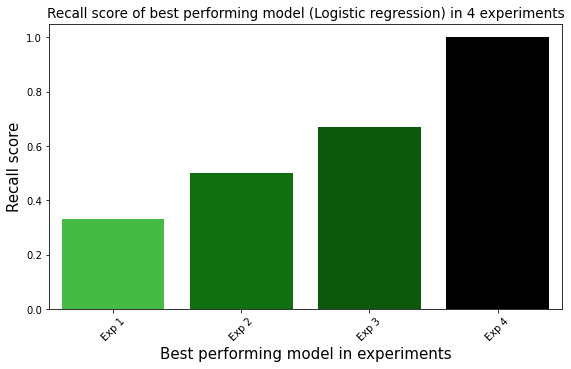

In [33]:
import seaborn as sns 
import matplotlib.pyplot as plt
color = ['limegreen','green','darkgreen','black']
plt.figure(figsize=(8,5))
# tmp =tmp[:17]
# make barplot and sort bars
sns.barplot(x='Models',
            y="Recall", 
            data=acc, 
            order=acc.sort_values('Recall',ascending=True).Models,palette=color)
# set labels
plt.xlabel("Best performing model in experiments", size=15)
plt.ylabel("Recall score", size=15)
plt.title("Recall score of best performing model (Logistic regression) in 4 experiments", size=13.5)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(r"C:\Users\aksha\Downloads\Thesis img\accuracy.png", dpi=200)


acc = pd.DataFrame({"Models":['Exp 1','Exp 2','Exp 3','Exp 4'],"F1-score":[0.5,0.6,0.67,0.89]})

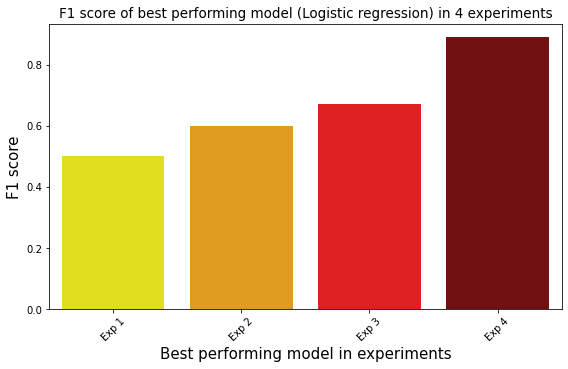

In [30]:
import seaborn as sns 
import matplotlib.pyplot as plt
color = ['yellow','orange','red','maroon','orange']

plt.figure(figsize=(8,5))
# tmp =tmp[:17]
# make barplot and sort bars
sns.barplot(x='Models',
            y="F1-score", 
            data=acc, 
            order=acc.sort_values('F1-score',ascending=True).Models, palette=color)
# set labels
plt.xlabel("Best performing model in experiments", size=15)
plt.ylabel("F1 score", size=15)
plt.title("F1 score of best performing model (Logistic regression) in 4 experiments", size=13.5)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(r"C:\Users\aksha\Downloads\Thesis img\accuracy.png", dpi=200)
